KNN

In [4]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty file: {file_path}")
    
    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")
    
    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer."""
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# KNN with GridSearchCV, SMOTE, and Confusion Matrix

def flastKNNWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)
    
    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")
    
    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    Z_resampled, y_resampled = smote.fit_resample(Z, dataLabelsList)

    print(f"After SMOTE: Number of data points: {Z_resampled.shape[0]}")

    # Define the KNN model
    knn = KNeighborsClassifier()

    # Expanded parameter grid for hyperparameter tuning
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
        'metric': ['cosine', 'euclidean'],  # Distance metrics
        'weights': ['uniform', 'distance'],  # Neighbor weighting schemes
    }

    # Custom scoring functions for precision, recall, accuracy, and F1 score
    scoring = {
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted') 
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform GridSearchCV with multiple scoring metrics
    grid_search = GridSearchCV(knn, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV on resampled data
    grid_search.fit(Z_resampled, y_resampled)

    # Get the best parameters and the best score for f1
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best F1 Score: {best_score}")

    # Save the results
    outFile = f"{combination_label}-params-knn-{n_splits}-folds.csv"
    with open(os.path.join(outDir, outFile), "w") as fo:
        fo.write("n_neighbors,metric,weights,accuracy,precision,recall,f1,preparationTime\n")
        for idx, param in enumerate(grid_search.cv_results_['params']):
            accuracy = grid_search.cv_results_['mean_test_accuracy'][idx]
            precision = grid_search.cv_results_['mean_test_precision'][idx]
            recall = grid_search.cv_results_['mean_test_recall'][idx]
            f1 = grid_search.cv_results_['mean_test_f1'][idx]
            preparationTime = vecTime / len(dataPoints)  
            fo.write(f"{param['n_neighbors']},{param['metric']},{param['weights']},{accuracy},{precision},{recall},{f1},{preparationTime}\n")

    # Print confusion matrices for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z_resampled, y_resampled), start=1):
        X_train, X_val = Z_resampled[train_idx], Z_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # Train the best model and predict on validation set
        grid_search.best_estimator_.fit(X_train, y_train)
        y_pred = grid_search.best_estimator_.predict(X_val)
        
        # Plot confusion matrix for each fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)
        print(f"Confusion Matrix for fold {fold_idx} generated.")

    print(f"KNN analysis completed for {n_splits}-folds. Results saved to: {outFile}")
    return best_params, best_score

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "C:/Users/kdeep/Downloads/Flakiness ML/cleaned_flaky_files.zip"
    largerNonFlakyZip = "C:/Users/kdeep/Downloads/Flakiness ML/all_nonflaky_files.zip"

    outDirLarger = "smote-results/larger_nonflaky/"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote-extracted/larger_nonflaky/"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Perform KNN analysis for the larger non-flaky combination (flaky vs larger non-flaky)
    print("Starting KNN analysis for flaky vs larger non-flaky files...")
    best_params_5folds_2, best_score_5folds_2 = flastKNNWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger")
    best_params_3folds_2, best_score_3folds_2 = flastKNNWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger")

    print("Best results for 5-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_5folds_2}")
    print(f"Best F1 Score: {best_score_5folds_2}")

    print("Best results for 3-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_3folds_2}")
    print(f"Best F1 Score: {best_score_3folds_2}")


ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (C:\Users\haha9\anaconda3\Lib\site-packages\sklearn\utils\metaestimators.py)

SVM

Starting SVM analysis for flaky vs larger non-flaky files...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
After SMOTE: Number of data points: 508
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Best F1 Score: 0.9822919916197387
[[49  2]
 [ 2 49]]


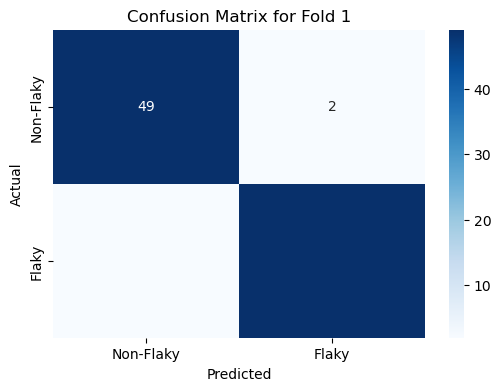

Confusion Matrix for fold 1 generated.
[[50  1]
 [ 0 51]]


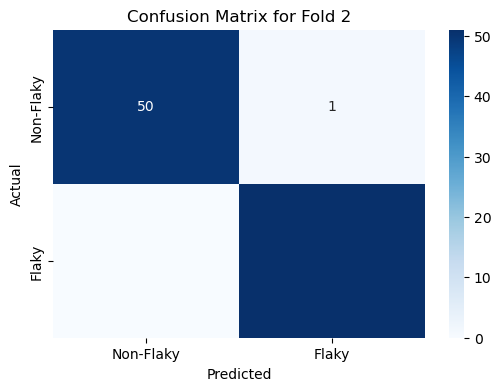

Confusion Matrix for fold 2 generated.
[[50  1]
 [ 0 51]]


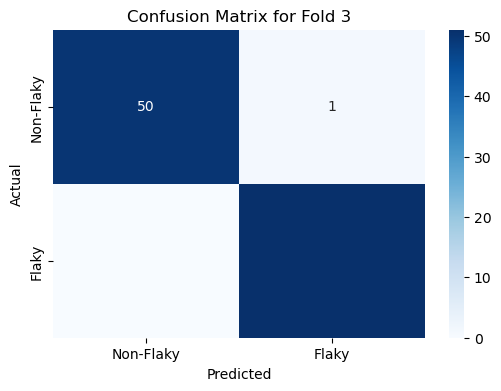

Confusion Matrix for fold 3 generated.
[[48  2]
 [ 0 51]]


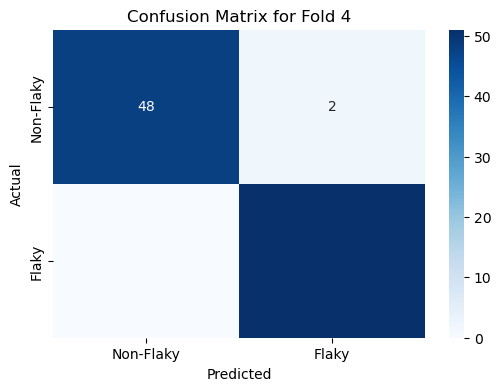

Confusion Matrix for fold 4 generated.
[[50  1]
 [ 0 50]]


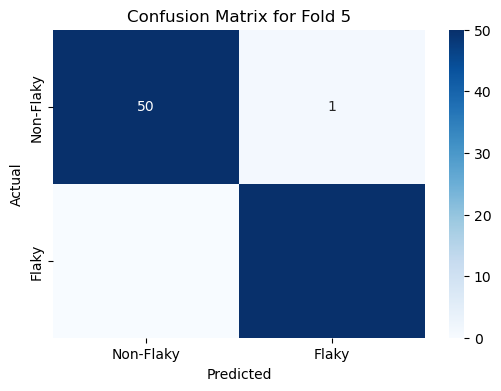

Confusion Matrix for fold 5 generated.
SVM analysis completed for 5-folds. Results saved to: larger-params-svm-5-folds.csv
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
After SMOTE: Number of data points: 508
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Best F1 Score: 0.9822921660535764
[[83  2]
 [ 2 83]]


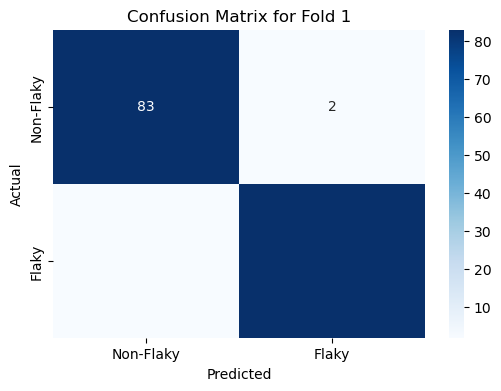

Confusion Matrix for fold 1 generated.
[[81  3]
 [ 0 85]]


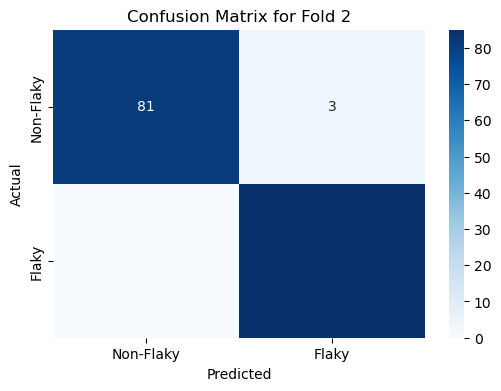

Confusion Matrix for fold 2 generated.
[[83  2]
 [ 0 84]]


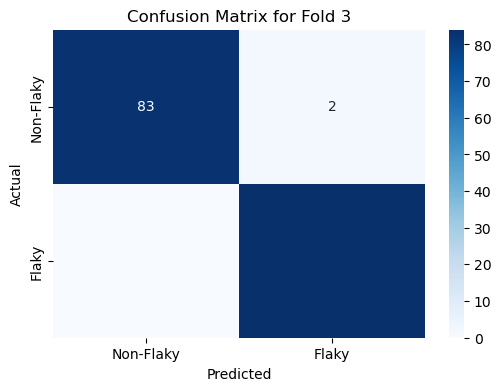

Confusion Matrix for fold 3 generated.
SVM analysis completed for 3-folds. Results saved to: larger-params-svm-3-folds.csv
Best results for 5-fold on larger non-flaky combination:
Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Best F1 Score: 0.9822919916197387
Best results for 3-fold on larger non-flaky combination:
Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Best F1 Score: 0.9822921660535764


In [17]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty file: {file_path}")
    
    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")
    
    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer."""
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# SVM with SMOTE, GridSearchCV, and Weighted Scoring

def flastSVMWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)
    
    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")
    
    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    Z_resampled, y_resampled = smote.fit_resample(Z, dataLabelsList)

    print(f"After SMOTE: Number of data points: {Z_resampled.shape[0]}")

    # Define the SVM model
    svm = SVC()

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization parameter
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Kernel types
    }

    # Custom scoring functions for precision, recall, accuracy, and F1 score with weighted average
    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted', zero_division=0)  
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform GridSearchCV with multiple scoring metrics
    grid_search = GridSearchCV(svm, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV on training data
    grid_search.fit(Z_resampled, y_resampled)

    # Get the best parameters and the best score for f1
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best F1 Score: {best_score}")

    # Save the results
    outFile = f"{combination_label}-params-svm-{n_splits}-folds.csv"
    with open(os.path.join(outDir, outFile), "w") as fo:
        fo.write("C,kernel,accuracy,precision,recall,f1,preparationTime\n")
        for idx, param in enumerate(grid_search.cv_results_['params']):
            accuracy = grid_search.cv_results_['mean_test_accuracy'][idx]
            precision = grid_search.cv_results_['mean_test_precision'][idx]
            recall = grid_search.cv_results_['mean_test_recall'][idx]
            f1 = grid_search.cv_results_['mean_test_f1'][idx]
            preparationTime = vecTime / len(dataPoints) 
            fo.write(f"{param['C']},{param['kernel']},{accuracy},{precision},{recall},{f1},{preparationTime}\n")

    # Print confusion matrices for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z_resampled, y_resampled), start=1):
        X_train, X_val = Z_resampled[train_idx], Z_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # Train the best model and predict on validation set
        grid_search.best_estimator_.fit(X_train, y_train)
        y_pred = grid_search.best_estimator_.predict(X_val)
        
        # Plot confusion matrix for each fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)
        print(f"Confusion Matrix for fold {fold_idx} generated.")

    print(f"SVM analysis completed for {n_splits}-folds. Results saved to: {outFile}")
    return best_params, best_score

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "C:/Users/kdeep/Downloads/Flakiness ML/cleaned_flaky_files.zip"
    largerNonFlakyZip = "C:/Users/kdeep/Downloads/Flakiness ML/all_nonflaky_files.zip"

    outDirLarger = "smote-results/larger_nonflaky/"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote-extracted/larger_nonflaky/"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Perform SVM analysis for the larger non-flaky combination (flaky vs larger non-flaky)
    print("Starting SVM analysis for flaky vs larger non-flaky files...")
    best_params_5folds_2, best_score_5folds_2 = flastSVMWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger")
    best_params_3folds_2, best_score_3folds_2 = flastSVMWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger")

    print("Best results for 5-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_5folds_2}")
    print(f"Best F1 Score: {best_score_5folds_2}")

    print("Best results for 3-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_3folds_2}")
    print(f"Best F1 Score: {best_score_3folds_2}")


Naive Bayes

Starting Naive Bayes analysis for flaky vs larger non-flaky files...
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
After SMOTE: Number of data points: 508
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'alpha': 0.1}
Best F1 Score: 0.9764218856949938
Naive Bayes analysis completed for 5-folds. Results saved to: larger-params-nb-5-folds.csv
[[49  2]
 [ 3 48]]


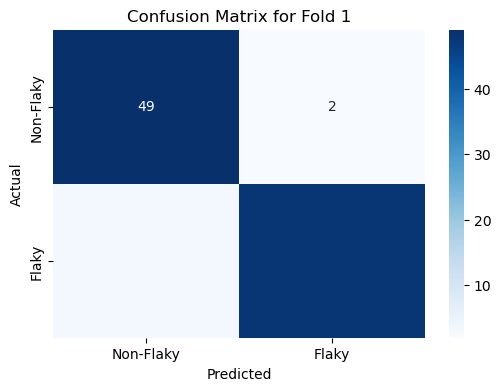

Predictions for fold 1: [1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual values for fold 1: [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[49  2]
 [ 0 51]]


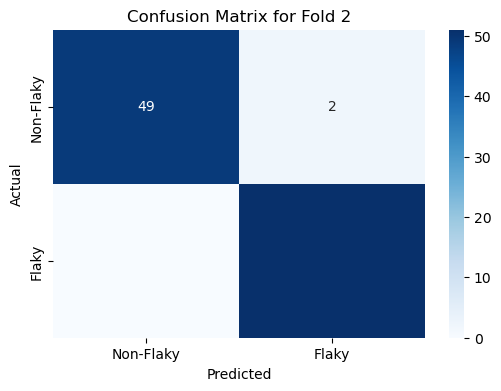

Predictions for fold 2: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual values for fold 2: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[48  3]
 [ 0 51]]


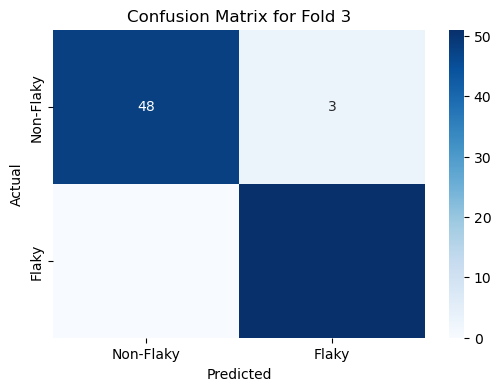

Predictions for fold 3: [1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual values for fold 3: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[48  2]
 [ 0 51]]


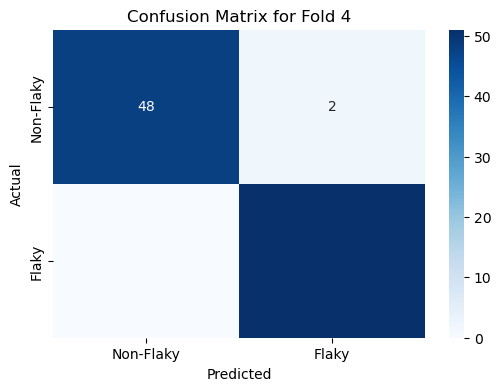

Predictions for fold 4: [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual values for fold 4: [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[51  0]
 [ 0 50]]


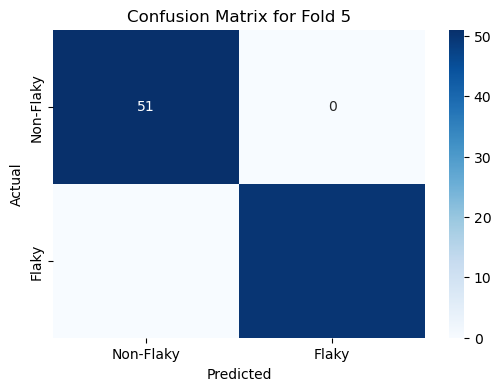

Predictions for fold 5: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual values for fold 5: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Number of flaky documents: 47
Number of non-flaky documents: 254
Total number of documents: 301
After SMOTE: Number of data points: 508
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'alpha': 0.001}
Best F1 Score: 0.9803167374347765
Naive Bayes analysis completed for 3-folds. Results saved to: larger-params-nb-3-folds.csv
[[83  2]
 [ 2 83]]


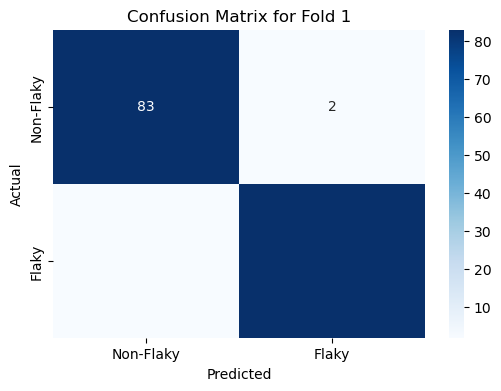

Predictions for fold 1: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual values for fold 1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[80  4]
 [ 0 85]]


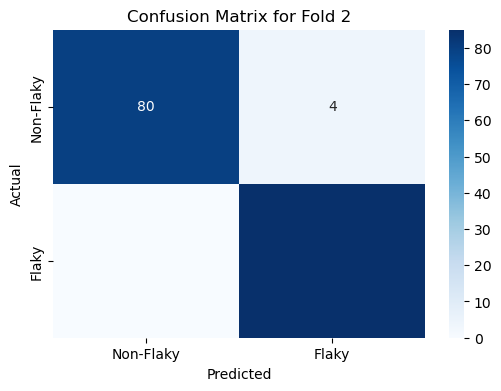

Predictions for fold 2: [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual values for fold 2: [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[83  2]
 [ 0 84]]


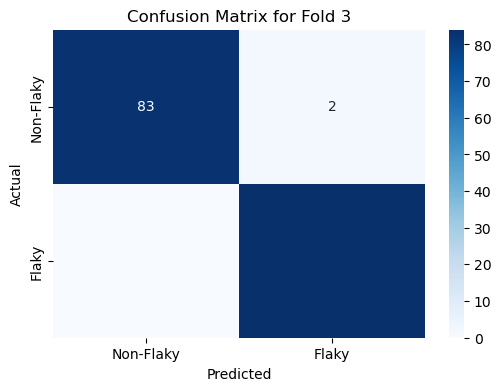

Predictions for fold 3: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual values for fold 3: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best results for 5-fold on larger non-flaky combination:
Best Parameters: {'alpha': 0.1}
Best F1 Score: 0.9764218856949938
Best results for 3-fold on larger non-flaky combination:
Best Parameters: {'alpha': 0.001}
Best F1 Score: 0.9803167374347765


In [15]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):  # Only consider Python files
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty file: {file_path}")
    
    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")
    
    return dataPointsList

def flastVectorization(dataPoints):
    """Vectorizes the data points using CountVectorizer without dimensionality reduction."""
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z = countVec.fit_transform(dataPoints)
    return Z

###############################################################################
# Function to plot confusion matrix

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# Naive Bayes with SMOTE, GridSearchCV, and Weighted Scoring

def flastNBWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, combination_label):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)
    
    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")
    
    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization without Random Projection
    Z = flastVectorization(dataPoints)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    Z_resampled, y_resampled = smote.fit_resample(Z, dataLabelsList)

    print(f"After SMOTE: Number of data points: {Z_resampled.shape[0]}")

    # Define the Naive Bayes model
    nb = MultinomialNB()

    # Parameter grid for hyperparameter tuning
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0], 
    }

    # Custom scoring functions for precision, recall, accuracy, and F1 score (weighted for imbalanced data)
    scoring = {
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted') 
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform GridSearchCV with multiple scoring metrics
    grid_search = GridSearchCV(nb, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV on resampled training data
    grid_search.fit(Z_resampled, y_resampled)

    # Get the best parameters and the best score for f1
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best F1 Score: {best_score}")

    # Save the results
    outFile = f"{combination_label}-params-nb-{n_splits}-folds.csv"
    with open(os.path.join(outDir, outFile), "w") as fo:
        fo.write("alpha,accuracy,precision,recall,f1,preparationTime\n")
        for idx, param in enumerate(grid_search.cv_results_['params']):
            accuracy = grid_search.cv_results_['mean_test_accuracy'][idx]
            precision = grid_search.cv_results_['mean_test_precision'][idx]
            recall = grid_search.cv_results_['mean_test_recall'][idx]
            f1 = grid_search.cv_results_['mean_test_f1'][idx]
            preparationTime = vecTime / len(dataPoints)  
            fo.write(f"{param['alpha']},{accuracy},{precision},{recall},{f1},{preparationTime}\n")

    print(f"Naive Bayes analysis completed for {n_splits}-folds. Results saved to: {outFile}")

    # Generate and print confusion matrix for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z_resampled, y_resampled), start=1):
        X_train, X_val = Z_resampled[train_idx], Z_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # Train and predict
        grid_search.best_estimator_.fit(X_train, y_train)
        y_pred = grid_search.best_estimator_.predict(X_val)
        
        # Plot confusion matrix
        plot_confusion_matrix(y_val, y_pred, fold_idx)
        
        # Print predictions for the validation set
        print(f"Predictions for fold {fold_idx}: {y_pred}")
        print(f"Actual values for fold {fold_idx}: {y_val}")

    return best_params, best_score

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "C:/Users/kdeep/Downloads/Flakiness ML/cleaned_flaky_files.zip"
    largerNonFlakyZip = "C:/Users/kdeep/Downloads/Flakiness ML/all_nonflaky_files.zip"

    outDirLarger = "smote-results/larger_nonflaky/"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote-extracted/larger_nonflaky/"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Perform Naive Bayes analysis for the larger non-flaky combination (flaky vs larger non-flaky)
    print("Starting Naive Bayes analysis for flaky vs larger non-flaky files...")
    best_params_5folds_2, best_score_5folds_2 = flastNBWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, "larger")
    best_params_3folds_2, best_score_3folds_2 = flastNBWithSMOTE(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, "larger")

    print("Best results for 5-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_5folds_2}")
    print(f"Best F1 Score: {best_score_5folds_2}")

    print("Best results for 3-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_3folds_2}")
    print(f"Best F1 Score: {best_score_3folds_2}")


XGB

Starting XGBoost analysis for flaky vs larger non-flaky files...
Empty file: smote-extracted/larger_nonflaky/nonFlaky\non-flakyMethods\PR1702\Qiskit_qiskit_PR1702_85b5af6100be236d97a3e0e77c8aba2ded185805_test_python_tools_visualization___init__.py
Number of flaky documents: 47
Number of non-flaky documents: 93
Total number of documents: 140
After SMOTE: Z_resampled shape: (186, 100), y_resampled shape: (186,)
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'eta': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best F1 Score: 0.8916368617489964
[[17  2]
 [ 0 19]]


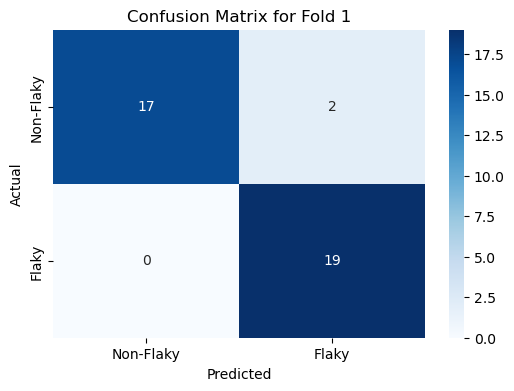

Confusion Matrix for fold 1 generated.
[[14  4]
 [ 2 17]]


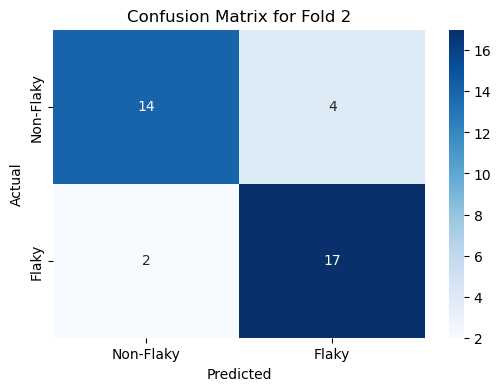

Confusion Matrix for fold 2 generated.
[[18  0]
 [ 1 18]]


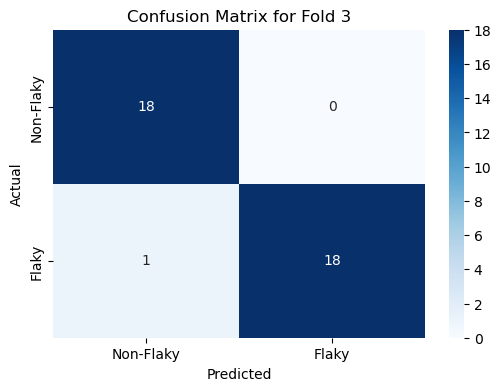

Confusion Matrix for fold 3 generated.
[[17  2]
 [ 5 13]]


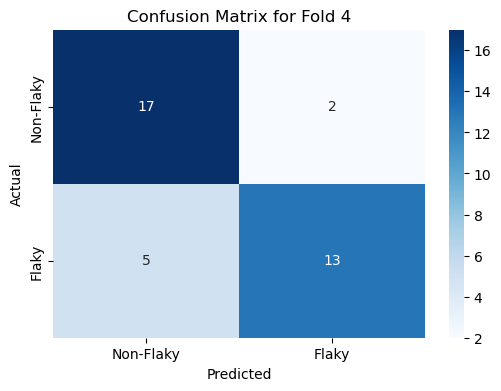

Confusion Matrix for fold 4 generated.
[[16  3]
 [ 1 17]]


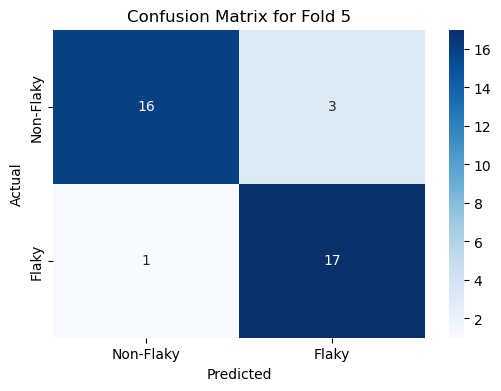

Confusion Matrix for fold 5 generated.
XGBoost analysis completed for 5-folds. Results saved to: larger-params-xgb-5-folds.csv
Empty file: smote-extracted/larger_nonflaky/nonFlaky\non-flakyMethods\PR1702\Qiskit_qiskit_PR1702_85b5af6100be236d97a3e0e77c8aba2ded185805_test_python_tools_visualization___init__.py
Number of flaky documents: 47
Number of non-flaky documents: 93
Total number of documents: 140
After SMOTE: Z_resampled shape: (186, 100), y_resampled shape: (186,)
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters: {'eta': 0.3, 'max_depth': 5, 'n_estimators': 50}
Best F1 Score: 0.8373456790123456
[[25  6]
 [ 4 27]]


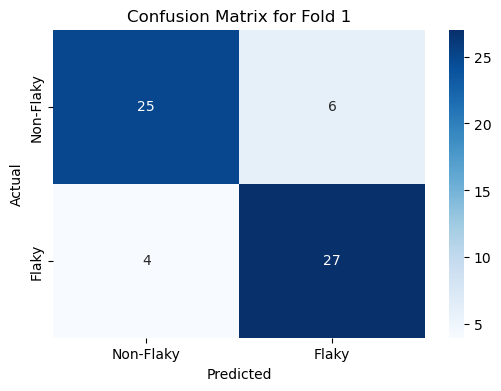

Confusion Matrix for fold 1 generated.
[[29  2]
 [ 4 27]]


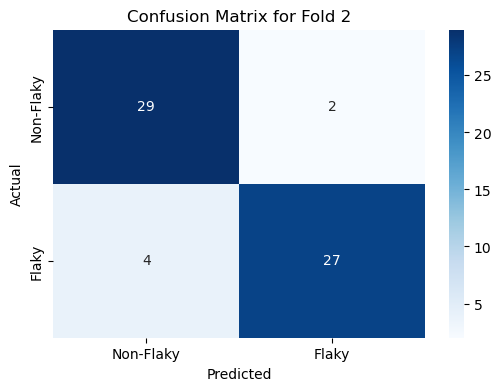

Confusion Matrix for fold 2 generated.
[[20 11]
 [ 3 28]]


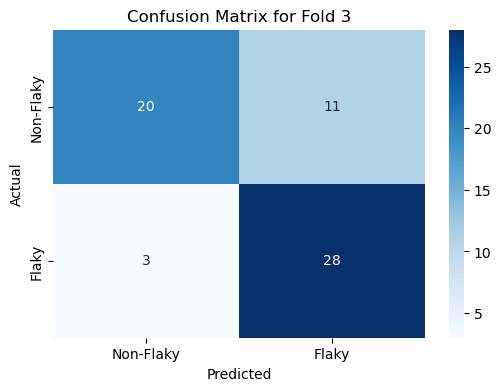

Confusion Matrix for fold 3 generated.
XGBoost analysis completed for 3-folds. Results saved to: larger-params-xgb-3-folds.csv
Best results for 5-fold on larger non-flaky combination:
Best Parameters: {'eta': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best F1 Score: 0.8916368617489964
Best results for 3-fold on larger non-flaky combination:
Best Parameters: {'eta': 0.3, 'max_depth': 5, 'n_estimators': 50}
Best F1 Score: 0.8373456790123456


In [12]:
import os
import time
import zipfile
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.random_projection import SparseRandomProjection

###############################################################################
# 유틸리티 함수들

def extract_zip(zip_file, extract_to):
    """지정된 디렉토리에 zip 파일을 해제합니다."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """주어진 디렉토리 내의 모든 .py 파일의 내용을 수집합니다."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):  # 파이썬 파일만 고려
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # 빈 파일이 아닌지 확인
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty file: {file_path}")

    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")

    return dataPointsList

def flastVectorization(dataPoints, dim=0, eps=0.3):
    """CountVectorizer를 사용하여 벡터화하고, 필요에 따라 차원 축소를 수행합니다."""
    countVec = CountVectorizer(stop_words=None)  # 불용어 제거 없음
    Z_full = countVec.fit_transform(dataPoints)
    if eps == 0:
        Z = Z_full
    else:
        if dim <= 0:
            dim = johnson_lindenstrauss_min_dim(Z_full.shape[0], eps=eps)
        srp = SparseRandomProjection(n_components=dim)
        Z = srp.fit_transform(Z_full)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """특정 폴드에 대한 혼동 행렬을 그립니다."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# XGBoost와 SMOTE 및 GridSearchCV를 사용한 모델

def flastXGBWithSMOTE(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, dim, eps, combination_label):
    v0 = time.perf_counter()

    
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')

    
    if os.path.exists(flakyDir):
        shutil.rmtree(flakyDir)
    if os.path.exists(nonFlakyDir):
        shutil.rmtree(nonFlakyDir)
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)

    
    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")

    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # 벡터화
    Z = flastVectorization(dataPoints, dim=dim, eps=eps)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0

  
    smote = SMOTE(random_state=42)
    Z_resampled, y_resampled = smote.fit_resample(Z, dataLabelsList)

    print(f"After SMOTE: Z_resampled shape: {Z_resampled.shape}, y_resampled shape: {y_resampled.shape}")

    if Z_resampled is None or y_resampled is None or len(y_resampled) == 0:
        raise ValueError("SMOTE failed to generate resampled data. Check input files and SMOTE configuration.")

    xgb_model = xgb.XGBClassifier(eval_metric="logloss")

    param_grid = {
        'eta': [0.01, 0.1, 0.3, 0.5],  # 학습률
        'max_depth': [3, 5, 7, 10],    # 트리 깊이
        'n_estimators': [50, 100, 200, 300],  # 부스팅 라운드 수
    }

    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=1), 
        'recall': make_scorer(recall_score, average='weighted'),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted', zero_division=1)  
    }

    # 교차 검증 설정
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # GridSearchCV 수행
    grid_search = GridSearchCV(xgb_model, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # 재샘플링된 데이터로 모델 학습
    grid_search.fit(Z_resampled, y_resampled)

    # 최적의 파라미터와 점수 출력
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best F1 Score: {best_score}")

    # 결과 저장
    outFile = f"{combination_label}-params-xgb-{n_splits}-folds.csv"
    with open(os.path.join(outDir, outFile), "w") as fo:
        fo.write("eta,max_depth,n_estimators,accuracy,precision,recall,f1,preparationTime\n")
        for idx, param in enumerate(grid_search.cv_results_['params']):
            accuracy = grid_search.cv_results_['mean_test_accuracy'][idx]
            precision = grid_search.cv_results_['mean_test_precision'][idx]
            recall = grid_search.cv_results_['mean_test_recall'][idx]
            f1 = grid_search.cv_results_['mean_test_f1'][idx]
            preparationTime = vecTime / len(dataPoints)  
            fo.write(f"{param['eta']},{param['max_depth']},{param['n_estimators']},{accuracy},{precision},{recall},{f1},{preparationTime}\n")

    # 각 폴드에 대한 혼동 행렬 출력 및 플롯
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z_resampled, y_resampled), start=1):
        X_train, X_val = Z_resampled[train_idx], Z_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # 최적 모델로 예측 수행
        grid_search.best_estimator_.fit(X_train, y_train)
        y_pred = grid_search.best_estimator_.predict(X_val)
        
        # 혼동 행렬 플롯
        plot_confusion_matrix(y_val, y_pred, fold_idx)
        print(f"Confusion Matrix for fold {fold_idx} generated.")

    print(f"XGBoost analysis completed for {n_splits}-folds. Results saved to: {outFile}")
    return best_params, best_score

if __name__ == "__main__":
    # flaky와 non-flaky 데이터셋 설정
    flakyZip = "compressedDataset/cleaned_flaky_files.zip"
    nonFlakyZip = "compressedDataset/reduced_nonflaky_files.zip"
    outDirLarger = "smote-results/larger_nonflaky/"
    nonFlakyUnbalance = "compressedDataset/non-flakyMethods.zip"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote-extracted/larger_nonflaky/"
    os.makedirs(extractDirLarger, exist_ok=True)

    # XGBoost 분석 수행
    print("Starting XGBoost analysis for flaky vs larger non-flaky files...")
    best_params_5folds_2, best_score_5folds_2 = flastXGBWithSMOTE(
        outDirLarger, flakyZip, nonFlakyUnbalance, extractDirLarger, 5, dim=100, eps=0.3, combination_label="larger"
    )
    best_params_3folds_2, best_score_3folds_2 = flastXGBWithSMOTE(
        outDirLarger, flakyZip, nonFlakyUnbalance, extractDirLarger, 3, dim=100, eps=0.3, combination_label="larger"
    )

    print("Best results for 5-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_5folds_2}")
    print(f"Best F1 Score: {best_score_5folds_2}")

    print("Best results for 3-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_3folds_2}")
    print(f"Best F1 Score: {best_score_3folds_2}")


Random Forest

Starting Random Forest analysis for flaky vs larger non-flaky files...
Empty file: smote-extracted/larger_nonflaky/nonFlaky\non-flakyMethods\PR1702\Qiskit_qiskit_PR1702_85b5af6100be236d97a3e0e77c8aba2ded185805_test_python_tools_visualization___init__.py
Number of flaky documents: 47
Number of non-flaky documents: 347
Total number of documents: 394
After SMOTE: Number of data points: 694
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best F1 Score: 0.9956728017182466
[[68  1]
 [ 0 70]]


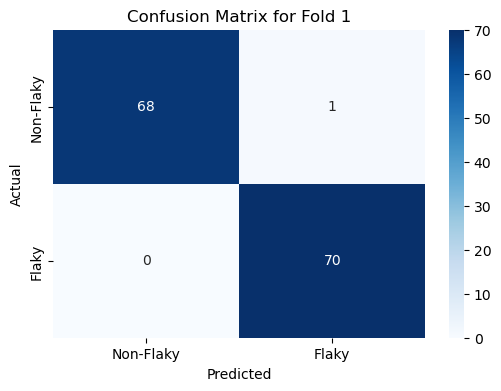

Confusion Matrix for fold 1 generated.
[[69  0]
 [ 0 70]]


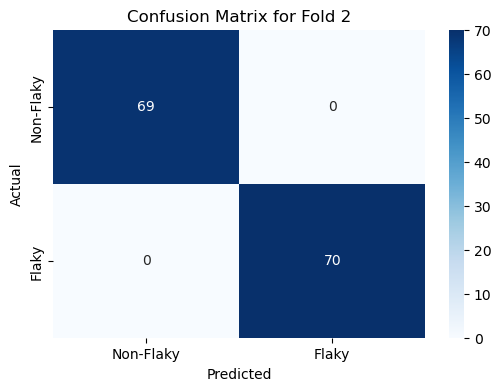

Confusion Matrix for fold 2 generated.
[[67  3]
 [ 0 69]]


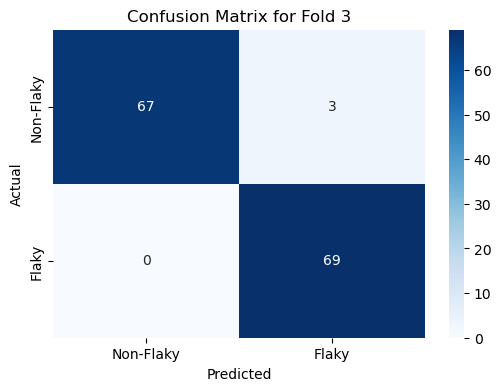

Confusion Matrix for fold 3 generated.
[[68  2]
 [ 2 67]]


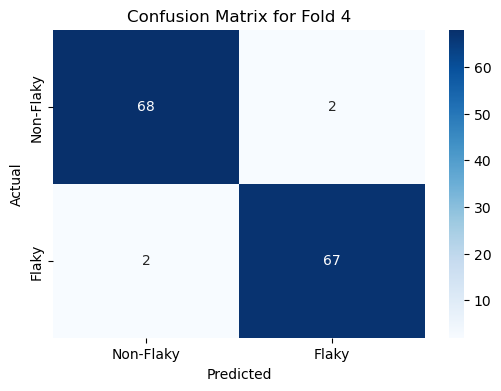

Confusion Matrix for fold 4 generated.
[[69  0]
 [ 2 67]]


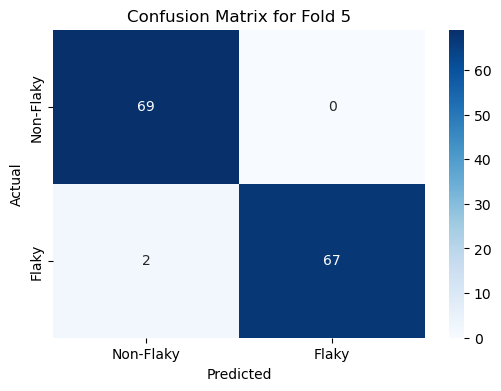

Confusion Matrix for fold 5 generated.
Random Forest analysis completed for 5-folds. Results saved to: larger-params-rf-5-folds.csv
Empty file: smote-extracted/larger_nonflaky/nonFlaky\non-flakyMethods\PR1702\Qiskit_qiskit_PR1702_85b5af6100be236d97a3e0e77c8aba2ded185805_test_python_tools_visualization___init__.py
Number of flaky documents: 47
Number of non-flaky documents: 347
Total number of documents: 394
After SMOTE: Number of data points: 694
Fitting 3 folds for each of 240 candidates, totalling 720 fits


C:\Users\haha9\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'criterion': 'gini', 'max_depth': 500, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best F1 Score: 0.9870518522166322
[[110   6]
 [  3 113]]


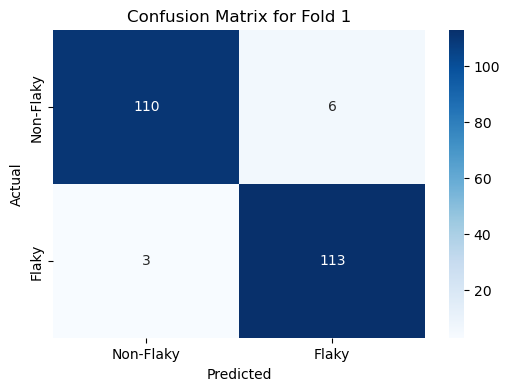

Confusion Matrix for fold 1 generated.
[[114   1]
 [  2 114]]


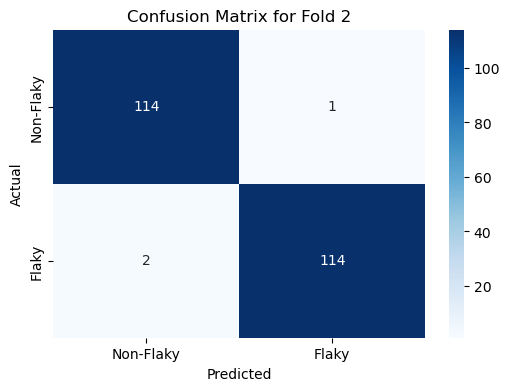

Confusion Matrix for fold 2 generated.
[[115   1]
 [  2 113]]


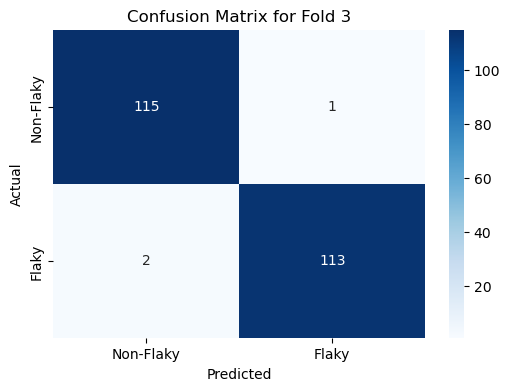

Confusion Matrix for fold 3 generated.
Random Forest analysis completed for 3-folds. Results saved to: larger-params-rf-3-folds.csv
Best results for 5-fold on larger non-flaky combination:
Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best F1 Score: 0.9956728017182466
Best results for 3-fold on larger non-flaky combination:
Best Parameters: {'criterion': 'gini', 'max_depth': 500, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best F1 Score: 0.9870518522166322


In [20]:
import os
import time
import zipfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.random_projection import SparseRandomProjection
from imblearn.over_sampling import SMOTE

###############################################################################
# Utility functions

def extract_zip(zip_file, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def getDataPoints(path):
    """Collects content of all .py files within the given directory."""
    dataPointsList = []
    if not os.path.exists(path):
        print(f"Directory does not exist: {path}")
        return dataPointsList

    for root, dirs, files in os.walk(path):
        for dataPointName in files:
            if dataPointName.endswith(".py"):  # Only consider Python files
                file_path = os.path.join(root, dataPointName)
                with open(file_path, encoding="utf-8") as fileIn:
                    dp = fileIn.read().strip()
                    if dp:  # Ensure the document is not empty
                        dataPointsList.append(dp)
                    else:
                        print(f"Empty file: {file_path}")
    
    if len(dataPointsList) == 0:
        print(f"No valid documents found in directory: {path}")
    
    return dataPointsList

def flastVectorization(dataPoints, dim=0, eps=0.3):
    """Performs vectorization using CountVectorizer with optional dimensionality reduction."""
    countVec = CountVectorizer(stop_words=None)  # No stop word removal
    Z_full = countVec.fit_transform(dataPoints)
    if eps == 0:
        Z = Z_full
    else:
        if dim <= 0:
            dim = johnson_lindenstrauss_min_dim(Z_full.shape[0], eps=eps)
        srp = SparseRandomProjection(n_components=dim)
        Z = srp.fit_transform(Z_full)
    return Z

def plot_confusion_matrix(y_true, y_pred, fold):
    """Plots confusion matrix for a particular fold."""
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flaky', 'Flaky'], yticklabels=['Non-Flaky', 'Flaky'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

###############################################################################
# Random Forest with GridSearchCV, SMOTE, and Confusion Matrix

def flastRFWithGridSearchCV(outDir, flakyZip, nonFlakyZip, extractDir, n_splits, dim, eps, combination_label):
    v0 = time.perf_counter()

    # Extract the zip files
    flakyDir = os.path.join(extractDir, 'flaky')
    nonFlakyDir = os.path.join(extractDir, 'nonFlaky')
    os.makedirs(flakyDir, exist_ok=True)
    os.makedirs(nonFlakyDir, exist_ok=True)
    
    extract_zip(flakyZip, flakyDir)
    extract_zip(nonFlakyZip, nonFlakyDir)

    dataPointsFlaky = getDataPoints(flakyDir)
    dataPointsNonFlaky = getDataPoints(nonFlakyDir)
    dataPoints = dataPointsFlaky + dataPointsNonFlaky

    print(f"Number of flaky documents: {len(dataPointsFlaky)}")
    print(f"Number of non-flaky documents: {len(dataPointsNonFlaky)}")
    print(f"Total number of documents: {len(dataPoints)}")
    
    if len(dataPoints) == 0:
        raise ValueError("No documents available for vectorization. Please check the input directories.")

    # Vectorization
    Z = flastVectorization(dataPoints, dim=dim, eps=eps)
    dataLabelsList = np.array([1]*len(dataPointsFlaky) + [0]*len(dataPointsNonFlaky))
    vecTime = time.perf_counter() - v0

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    Z_resampled, y_resampled = smote.fit_resample(Z, dataLabelsList)

    print(f"After SMOTE: Number of data points: {Z_resampled.shape[0]}")

    # Define Random Forest model
    rf_model = RandomForestClassifier()

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [10, 50, 100, 300, 500],  # Number of trees
        'max_depth': [10, 30, 50, 100, 300, 500],  # Maximum depth of each tree
        'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
        "criterion": ["gini", "entropy"], # Function to measure the quality of a split
    }

    # Custom scoring functions for precision, recall, accuracy, and F1 score (weighted)
    scoring = {
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted')
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform GridSearchCV with multiple scoring metrics
    grid_search = GridSearchCV(rf_model, param_grid, cv=skf, scoring=scoring, refit='f1', verbose=1, return_train_score=True)

    # Fit the GridSearchCV on resampled data
    grid_search.fit(Z_resampled, y_resampled)

    # Get the best parameters and the best score for F1
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best F1 Score: {best_score}")

    # Save the results
    outFile = f"{combination_label}-params-rf-{n_splits}-folds.csv"
    with open(os.path.join(outDir, outFile), "w") as fo:
        fo.write("n_estimators,max_depth,min_samples_split,min_samples_leaf,criterion,accuracy,precision,recall,f1,preparationTime\n")
        for idx, param in enumerate(grid_search.cv_results_['params']):
            accuracy = grid_search.cv_results_['mean_test_accuracy'][idx]
            precision = grid_search.cv_results_['mean_test_precision'][idx]
            recall = grid_search.cv_results_['mean_test_recall'][idx]
            f1 = grid_search.cv_results_['mean_test_f1'][idx]
            preparationTime = vecTime / len(dataPoints)  
            fo.write(f"{param['n_estimators']},{param['max_depth']},{param['min_samples_split']},{param['min_samples_leaf']},{param['criterion']},{accuracy},{precision},{recall},{f1},{preparationTime}\n")

    # Print confusion matrices for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(Z_resampled, y_resampled), start=1):
        X_train, X_val = Z_resampled[train_idx], Z_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]
        
        # Train the best model and predict on validation set
        grid_search.best_estimator_.fit(X_train, y_train)
        y_pred = grid_search.best_estimator_.predict(X_val)
        
        # Plot confusion matrix for each fold
        plot_confusion_matrix(y_val, y_pred, fold_idx)
        print(f"Confusion Matrix for fold {fold_idx} generated.")

    print(f"Random Forest analysis completed for {n_splits}-folds. Results saved to: {outFile}")
    return best_params, best_score

if __name__ == "__main__":
    # Parameters setup for the flaky vs larger non-flaky combination
    flakyZip = "compressedDataset/cleaned_flaky_files.zip"
    largerNonFlakyZip = "compressedDataset/all_nonflaky_files.zip"

    outDirLarger = "smote-results/larger_nonflaky/"
    os.makedirs(outDirLarger, exist_ok=True)
    extractDirLarger = "smote-extracted/larger_nonflaky/"
    os.makedirs(extractDirLarger, exist_ok=True)

    # Perform Random Forest analysis for flaky vs larger non-flaky files
    print("Starting Random Forest analysis for flaky vs larger non-flaky files...")
    best_params_5folds_2, best_score_5folds_2 = flastRFWithGridSearchCV(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 5, dim=100, eps=0.3, combination_label="larger")
    best_params_3folds_2, best_score_3folds_2 = flastRFWithGridSearchCV(outDirLarger, flakyZip, largerNonFlakyZip, extractDirLarger, 3, dim=100, eps=0.3, combination_label="larger")

    print("Best results for 5-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_5folds_2}")
    print(f"Best F1 Score: {best_score_5folds_2}")

    print("Best results for 3-fold on larger non-flaky combination:")
    print(f"Best Parameters: {best_params_3folds_2}")
    print(f"Best F1 Score: {best_score_3folds_2}")
